# Preprocess

preprocess functions

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler

VERSION = 1
BATCH = 32


def age_average(names, ages):
  master_count, mr_count, mrs_count, miss_count = 0, 0, 0, 0
  master_sum, mr_sum, mrs_sum, miss_sum = 0, 0, 0, 0
  for i in range(len(names)):
    name = names[i]
    age = ages[i]
    if not np.isnan([age]):
      if "Mr" in name:
        mr_count += 1
        mr_sum += age
      elif "Master" in name:
        master_count += 1
        master_sum += age
      elif "Miss" in name:
        miss_count += 1
        miss_sum += age
      else:
        mrs_count += 1
        mrs_sum += age
  return master_sum / master_count, mr_sum / mr_count, miss_sum / miss_count, mrs_sum / mrs_count

def replace_null_age(names, ages):
  total_avg = ages.mean()
  master_avg, mr_avg, miss_avg, mrs_avg = age_average(names, ages)
  for i in range(len(names)):
    name = names[i]
    age = ages[i]
    if np.isnan([age]):
      if "Mr" in name:
        ages[i] = mr_avg
      elif "Master" in name:
        ages[i] = master_avg
      elif "Miss" in name:
        ages[i] = miss_avg
      elif "Mrs" in name:
        ages[i] = Mrs_avg
      else:
        ages[i] = total_avg
  return ages.astype(int)

def replace_age(ages):
  for i in range(len(ages)):
    age = ages[i]
    if age <= 15:
      ages[i] = 1
    elif age <= 30:
      ages[i] = 2
    elif age <= 50:
      ages[i] = 3
    else:
      ages[i] = 4
  return ages.astype(int)

data = pd.read_csv("train.csv",  index_col=False)



In [2]:
def name_to_title(names):
  newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}
  title = names.apply(lambda x: x.split('.')[0].split(',')[1].strip())
  title = title.map(newtitles)
  return title
  

In [3]:
def replace_sibSp(sibSp):
  for i in range(len(sibSp)):
    sibsp = sibSp[i]
    if sibsp >= 3:
      sibSp[i] = 3
  return sibSp.astype(int)

In [4]:
def replace_parch(Parch):
  for i in range(len(Parch)):
    parch = Parch[i]
    if parch >= 2:
      Parch[i] = 2
  return Parch.astype(int)

In [5]:
def fare_to_ticket(fares, tickets):
  dic = dict()
  for ticket in tickets:
    if ticket in dic:
      dic[ticket] = dic[ticket] + 1 
    else:
      dic[ticket] = 1
  fare_2_ticket = []
  for i in range(len(fares)):
    fare_2_ticket.append(fares[i] / dic[tickets[i]])
  return fare_2_ticket



# Correlation Matrix

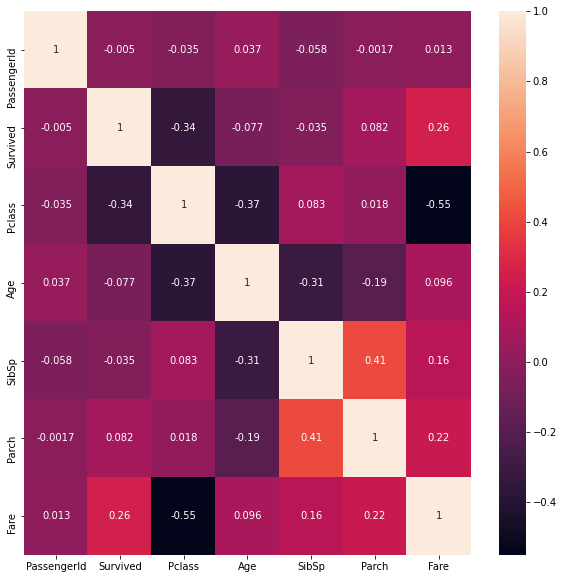

In [6]:
plt.figure(figsize=(10, 10))
ax = plt.subplot()
cm = data.corr()
sns.heatmap(cm, annot = True, ax = ax);

#Pre process

In [7]:
data["Age"] = replace_null_age(data["Name"], data["Age"])
data["Age"] = replace_age(data["Age"])
data["Embarked"] = data["Embarked"].fillna("S")
data["Title"] = name_to_title(data["Name"])
data["SibSp"] = replace_sibSp(data["SibSp"])
data["Parch"] = replace_parch(data["Parch"])
data["Fare$Ticket"] = fare_to_ticket(data["Fare"], data["Ticket"])
data["Fare"] = data["Fare"] / np.linalg.norm(data["Fare"])
data["Fare$Ticket"] = data["Fare$Ticket"] / np.linalg.norm(data["Fare$Ticket"])
data = pd.get_dummies(data, columns=["Parch", "Embarked", "Pclass", "Age", "SibSp", "Title"])
data = data.drop(columns=["PassengerId", "Cabin", "Name", "Ticket", "Sex"])


#new correlation matrix

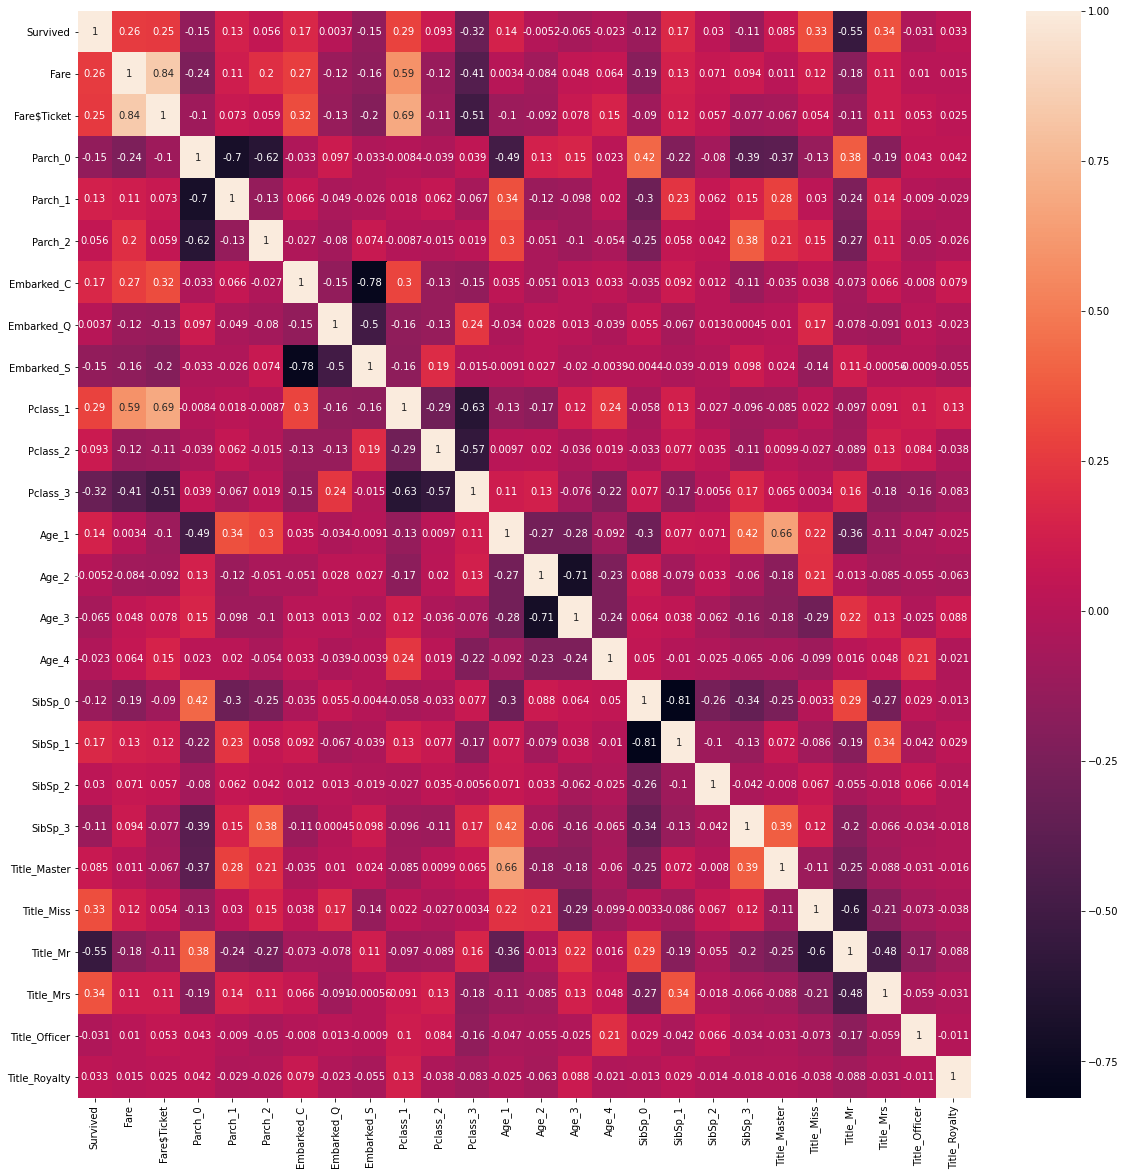

In [8]:

plt.figure(figsize=(20, 20))
ax = plt.subplot()
cm = data.corr()
sns.heatmap(cm, annot = True, ax = ax);

In [9]:
def pre_process(data):
  data["Age"] = replace_null_age(data["Name"], data["Age"])
  data["Age"] = replace_age(data["Age"])
  data["Title"] = name_to_title(data["Name"])
  data["SibSp"] = replace_sibSp(data["SibSp"])
  data["Parch"] = replace_parch(data["Parch"])
  data["Fare$Ticket"] = fare_to_ticket(data["Fare"], data["Ticket"])
  data["Fare"] = data["Fare"] / np.linalg.norm(data["Fare"])
  data["Fare$Ticket"] = data["Fare$Ticket"] / np.linalg.norm(data["Fare$Ticket"])
  data = pd.get_dummies(data, columns=["Parch", "Embarked", "Pclass", "Age", "SibSp", "Title"])
  data = data.drop(columns=["PassengerId", "Cabin", "Name", "Ticket", "Sex"])
  return data


In [10]:
from sklearn.model_selection import train_test_split

y = data["Survived"]
X = data.drop(["Survived"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
def get_ds(x_train, x_test, y_train, y_test, batch_size, buffer_size=10000):
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(buffer_size).batch(batch_size)

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    return train_ds, test_ds

In [12]:
train_ds, test_ds = get_ds(X_train, X_test, y_train, y_test, BATCH)

In [13]:
from keras.layers import Dropout

class Model(Model):
  def __init__(self):
    super(Model, self).__init__()
    self.d1 = Dense(3, activation='relu')
    self.d2 = Dense(2, activation='relu')
    self.d3 = Dense(1, 'sigmoid')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return x


In [14]:
model = Model()

In [15]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()


In [16]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
train_recall = tf.keras.metrics.Recall(name='train_recall')
train_precision = tf.keras.metrics.Precision(name='train_precision')


test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
test_recall = tf.keras.metrics.Recall(name='test_recall')
test_precision = tf.keras.metrics.Precision(name='test_precision')

In [17]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  train_recall(labels, predictions)
  train_precision(labels, predictions)

In [18]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
  test_recall(labels, predictions)
  test_precision(labels, predictions)

In [19]:
EPOCHS = 150

def train_model():
  train_loss_values = []
  test_loss_values = []
  train_acc_values = []
  test_acc_values = []
  train_recall_values = []
  train_precision_values = []
  test_recall_values = []
  test_precision_values = []



  for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
      train_step(images, labels)

    for test_images, test_labels in test_ds:
      test_step(test_images, test_labels)
    
    
    model.save_weights(f'weights/V{VERSION}/weights_epoch_{epoch}')
    train_loss_values.append(train_loss.result())
    test_loss_values.append(test_loss.result())
    train_acc_values.append(train_accuracy.result())
    test_acc_values.append(test_accuracy.result())
    train_recall_values.append(train_recall.result())
    train_precision_values.append(train_precision.result())
    test_recall_values.append(test_recall.result())
    test_precision_values.append(test_precision.result())

    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result():.4f}, '
      f'Accuracy: {train_accuracy.result() * 100:.4f}, '
      f'recall: {train_recall.result():.3f}, '
      f'precision: {train_precision.result():.3f}, '
      f'Test Loss: {test_loss.result():.4f}, '
      f'Test Accuracy: {test_accuracy.result() * 100:.4f}, '
      f'Test recall: {test_recall.result():.4f}, '
      f'Test precision: {test_precision.result():.4f}'
    )
  np.save(f'results/V{VERSION}/train_loss.npy', train_loss_values)
  np.save(f'results/V{VERSION}/test_loss.npy', test_loss_values)
  np.save(f'results/V{VERSION}/train_acc.npy', train_acc_values)
  np.save(f'results/V{VERSION}/test_acc.npy', test_acc_values)
  np.save(f'results/V{VERSION}/train_recall.npy', train_recall_values)
  np.save(f'results/V{VERSION}/test_recall.npy', test_recall_values)
  np.save(f'results/V{VERSION}/train_precision.npy', train_precision_values)
  np.save(f'results/V{VERSION}/test_precision.npy', test_precision_values)
  return train_loss_values, test_loss_values, train_acc_values, test_acc_values, train_recall_values, train_precision_values, test_recall_values, test_precision_values

In [20]:

train_loss_values, test_loss_values, train_acc_values, test_acc_values, train_recall_values, train_precision_values, test_recall_values, test_precision_values = train_model()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.6902, Accuracy: 61.0054, recall: 0.000, precision: 0.000, Test Loss: 0.6846, Test Accuracy: 64.5285, Test recall: 0.0000, Test precision: 0.0000
Epoch 2, Loss: 0.6820, Accuracy: 61.4130, recall: 0.000, precision: 0.000, Test Loss: 0.6737, Test Accuracy: 64.5285, Test recall: 0.0000, Test precision: 0.0000
Epoch 3, Loss: 0.6706, Accuracy: 61.0054, recall: 0.000, precision: 0.000, Test Loss: 0.6548, Test Accuracy: 64.5285, Test recall: 0.0000, Test precision: 0.0000
Epoch 4, Loss: 0.6495,

# Random Forest

train_acc: 0.8426966292134831 test_acc: 0.8324022346368715


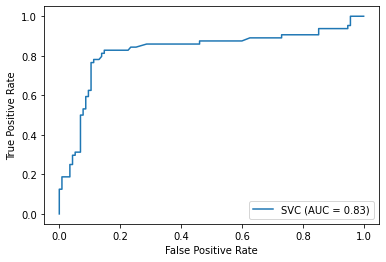

In [32]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(max_depth=4, n_estimators=20, min_samples_leaf=1)
tree.fit(X_train, y_train)
train_acc = tree.score(X_train, y_train)
test_acc = tree.score(X_test, y_test)
metrics.plot_roc_curve(svc, X_test, y_test)
plt.show()
print("train_acc:", train_acc, "test_acc:", test_acc)

# SVM

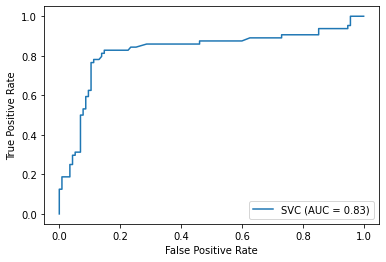

train_acc:  0.8132022471910112 test_acc:  0.8435754189944135


In [22]:
from sklearn.svm import SVC
from sklearn import metrics
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
train_acc = svc.score(X_train, y_train)
test_acc = svc.score(X_test, y_test)
metrics.plot_roc_curve(svc, X_test, y_test)
plt.show()
print("train_acc: ", train_acc, "test_acc: ", test_acc)

# AdaBoost

train_acc:  0.8132022471910112 test_acc:  0.8491620111731844


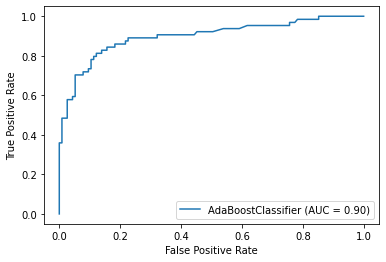

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
booster = AdaBoostClassifier(n_estimators=100, random_state=0, base_estimator=LogisticRegression())
booster.fit(X_train, y_train)
train_acc = booster.score(X_train, y_train)
test_acc = booster.score(X_test, y_test)
print("train_acc: ", train_acc, "test_acc: ", test_acc)
metrics.plot_roc_curve(booster, X_test, y_test)
plt.show()



# K Nearest

train_acc:  0.8497191011235955 test_acc:  0.7821229050279329


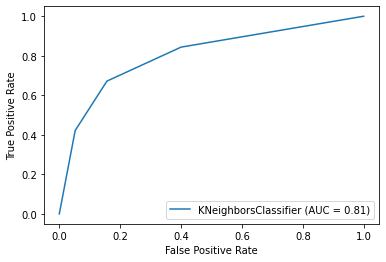

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
train_acc = neigh.score(X_train, y_train)
test_acc = neigh.score(X_test, y_test)
print("train_acc: ", train_acc, "test_acc: ", test_acc)
metrics.plot_roc_curve(neigh, X_test, y_test)
plt.show()

# Bagging

train_acc:  0.851123595505618 test_acc:  0.8212290502793296


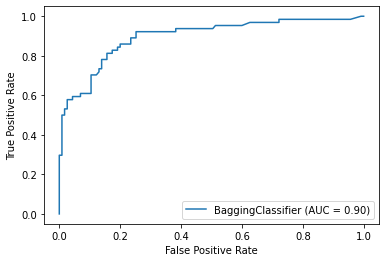

In [25]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=7, n_estimators=100,  min_samples_leaf=3), n_estimators=2).fit(X_train, y_train)
train_acc = bagging.score(X_train, y_train)
test_acc = bagging.score(X_test, y_test)
print("train_acc: ", train_acc, "test_acc: ", test_acc)
metrics.plot_roc_curve(bagging, X_test, y_test)
plt.show()

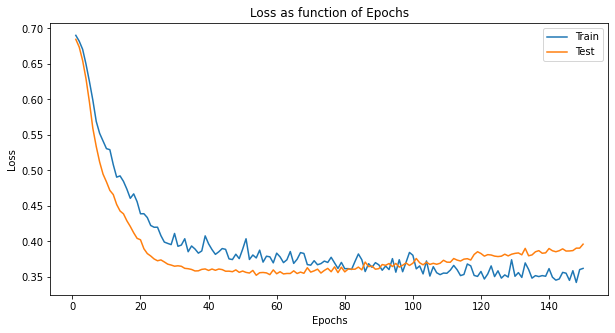

In [26]:
plt.figure(figsize=[10,5])
plt.plot(np.arange(EPOCHS) + 1, train_loss_values, label='Train')
plt.plot(np.arange(EPOCHS) + 1, test_loss_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as function of Epochs')
plt.legend()
plt.savefig('/content/figures/loss.png', dpi=300)
plt.show()

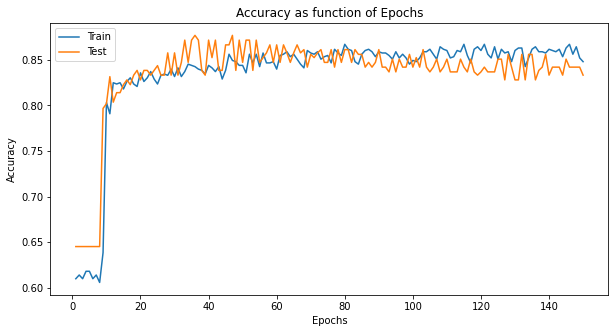

In [27]:
plt.figure(figsize=[10,5])
plt.plot(np.arange(EPOCHS) + 1, train_acc_values, label='Train')
plt.plot(np.arange(EPOCHS) + 1, test_acc_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy as function of Epochs')
plt.legend()
plt.savefig('/content/figures/_acc.png', dpi=300)
plt.show()

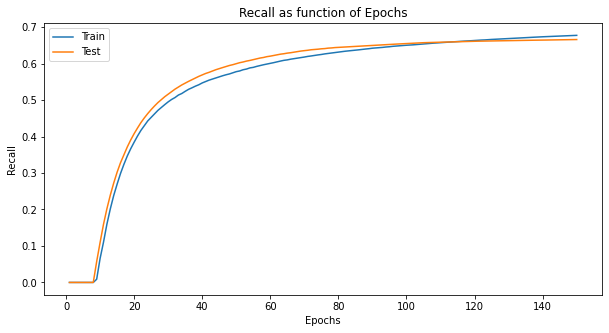

In [28]:
plt.figure(figsize=[10,5])
plt.plot(np.arange(EPOCHS) + 1, train_recall_values, label='Train')
plt.plot(np.arange(EPOCHS) + 1, test_recall_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall as function of Epochs')
plt.legend()
plt.savefig('/content/figures/recall.png', dpi=300)
plt.show()

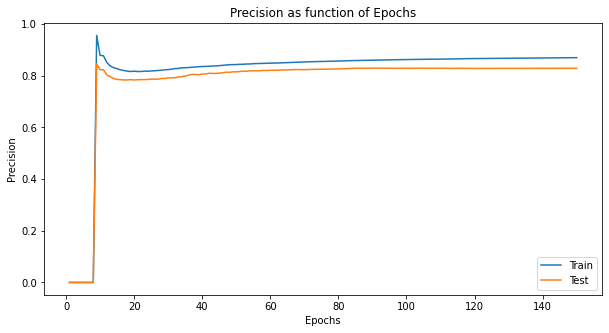

In [29]:
plt.figure(figsize=[10,5])
plt.plot(np.arange(EPOCHS) + 1, train_precision_values, label='Train')
plt.plot(np.arange(EPOCHS) + 1, test_precision_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision as function of Epochs')
plt.legend()
plt.savefig('/content/figures/_precision.png', dpi=300)
plt.show()

In [31]:

model.load_weights("/content/weights/V1/weights_epoch_149")
test_data = pd.read_csv("test.csv",  index_col=False)
ids = test_data["PassengerId"]
fare_mean = data["Fare"].mean()
test_data["Fare"] = test_data["Fare"].fillna(fare_mean)
test_data = pre_process(test_data)

y_pred = model.predict(test_data)
y_pred = y_pred.round().flatten()

# y_pred = bagging.predict(test_data)

a = {"PassengerId": ids, "Survived": y_pred}
answer = pd.DataFrame(a)
answer.to_csv("/content/results.csv")